In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import unit_impulse
#from findiff import FinDiff
#from sympy import symbols, solve

In [2]:
def forward_difference(y , dx):
    if len(y) == 1:
        return 0
    dydx = np.array(len(y)*[0.00])
    for i in range(len(y)-1):
        dydx[i] = (y[i+1] - y[i])/(dx)
    
    dydx[-1] = (y[-1] - y[-2])/(dx)
    
    return dydx
        
        

In [3]:
def disc_deriv(x , y):
    dy = np.array(len(y)*[0.00])
    num_discs = 0 #number of jumps
    size_jump = np.array([])  #size of the jump
    index_jump = np.array([] , dtype = int) #index AFTER which jump occurs
    
    for i in range(len(y)-1):
        dy[i] = (y[i+1] - y[i])
        
        if abs(dy[i]) >= np.pi:   #definining minimum size of a jump as pi
            #print("jump spotted")
            num_discs = num_discs + 1
            size_jump = np.append(size_jump , dy[i])
            #print(size_jump)
            index_jump = np.append(index_jump , i)
        
    
            
    #print(num_discs)
    function_subsets = (num_discs + 1)*[0.00]  #each element of this list will have a piece of the piecewise input function
    #print(len(function_subsets))
    #print(index_jump)
    
    if num_discs == 0:
        return y , 0
    
    starting_index = 0
    
    for i in range(len(function_subsets)-1):
        function_subsets[i] = y[starting_index:index_jump[i]+1]
        starting_index = index_jump[i]+1
    function_subsets[-1] = y[starting_index:]

    
    return function_subsets , size_jump
        
        

In [4]:
def nearest_multiple_of_pi(phase):
    if phase>=0:
        return (phase//pi)*pi
    else:
        return ((phase//pi)+1)*pi
        


def make_periodic(phase):
    if nearest_multiple_of_pi(phase) >= 0:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return -(pi - (phase - nearest_multiple_of_pi(phase)))
    else:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return (pi + (phase - nearest_multiple_of_pi(phase)))
        


In [5]:
pi = np.pi

In [6]:
"""Defining the template for the di and df vectors, in terms of a quenching parameter which perturbs the v and w values"""

v_quench_param = 0.5
w_quench_param = -0.5

#N = 1000
k = np.linspace(-pi , pi , 1001)
kp = k[np.where(k==0)[0][0]:]
kp_index = np.where(k==0)[0][0]
dk = k[1]-k[0]
t = np.linspace(0 , 30 , 1000)

def v(quench = False):
    v = 1
    if quench:
        return v + v_quench_param
    else:
        return v
    
def w(quench = False):
    w = 1.5
    if quench:
        return w + w_quench_param
    else:
        return w


In [7]:
def get_PGP(t , k):
    
    Eik = np.sqrt(v()**2 + w()**2 + 2*v()*w()*np.cos(k))
    Efk = np.sqrt(v(quench=True)**2 + w(quench=True)**2 + 2*v(quench=True)*w(quench=True)*np.cos(k))
    
    di_normed = (1/Eik)*np.array([v() + w()*np.cos(k) , -w()*np.sin(k)])
    df_normed = (1/Efk)*np.array([v(quench=True) + w(quench=True)*np.cos(k) , -w(quench=True)*np.sin(k)])
    
    cos_delta_k = np.dot(di_normed , df_normed)
    
    Gk = complex(np.cos(Efk*t) , -cos_delta_k*np.sin(Efk*t))
    phi_k = np.angle(Gk)
    
    phi_dyn = np.angle(complex(np.cos(-Efk*t*cos_delta_k) , np.sin(-Efk*t*cos_delta_k)))
    
    PGP = make_periodic(phi_k - phi_dyn)  #also try doing np.angle instead of make_periodic
    
    return PGP
    

In [11]:
def get_dnu_from_PGP(t , k , h):
    dnu = (get_PGP(t , k+h) - get_PGP(t , k))/h
    
    return dnu

In [12]:
k1 = np.linspace(0,np.pi,1001)
t1 = np.linspace(0,50,1000)

PGP = np.zeros((len(t1) , len(k1)))

for i in tqdm(range(len(t))):
    for j in range(len(k)):
        PGP[i,j] = get_PGP(t1[i] , k1[j])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
dnu = np.zeros((len(t1) , len(k1)))

for i in tqdm(range(len(t))):
    for j in range(len(k)):
        dnu[i,j] = get_dnu_from_PGP(t1[i] , k1[j] , 0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
nu = np.array(len(t1)*[0.00])

for i in range(len(t1)):
    nu[i] = np.trapz(dnu[i] , dx = k1[1] - k1[0])

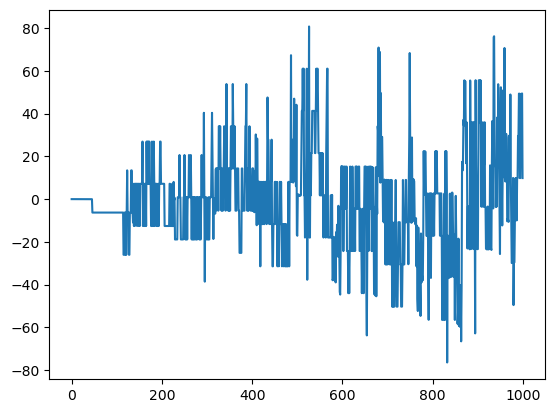

In [39]:
plt.plot(nu)

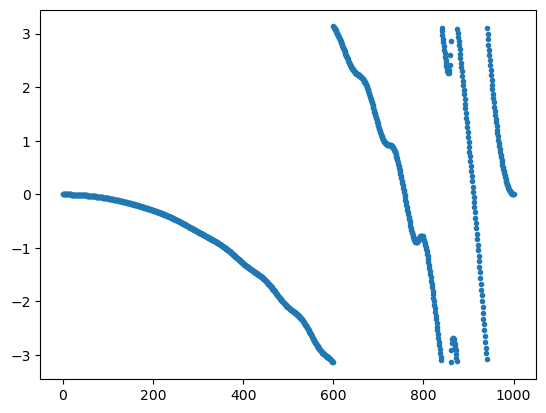

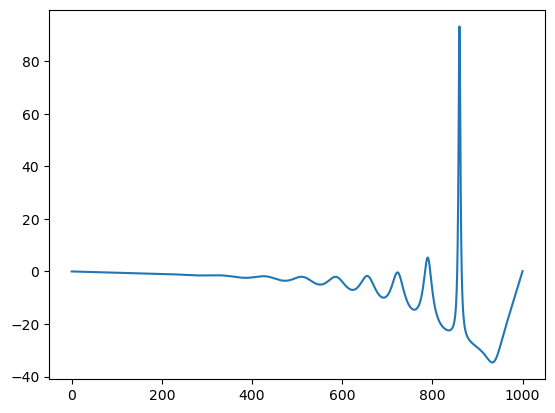

In [46]:
plt.plot(PGP[300] , ".")
plt.figure()
plt.plot(dnu[300])

In [44]:
np.shape(PGP)

(1000, 1001)

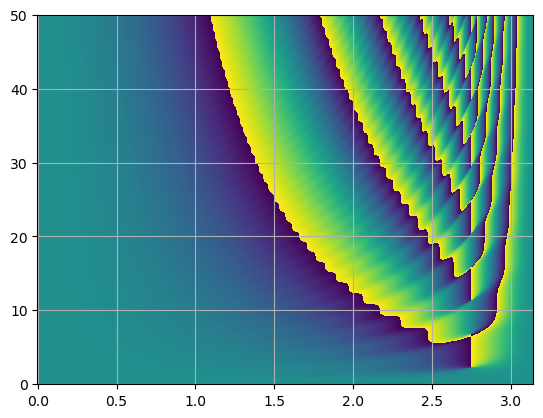

In [20]:
plt.pcolormesh(k1 , t1 , PGP)
plt.grid()
#plt.xlim(0,np.pi)

In [6]:
"""Now constructing the actual di and df vectors"""

di_list = len(k)*[0.0]
df_list = len(k)*[0.0]

for i in range(len(k)):
    di_list[i] = [v() + w()*np.cos(k[i]) , -w()*np.sin(k[i])]
    df_list[i] = [v(quench=True) + w(quench=True)*np.cos(k[i]) , -w(quench=True)*np.sin(k[i])]

In [7]:
"""Converting the di and df lists to arrays for easy operation later"""

di = np.array(di_list)
df = np.array(df_list)

In [8]:
v(quench=True) + w(quench=True)*np.cos(-pi)

0.5

In [9]:
# #plt.plot(np.array(di)[:,0])
# plt.plot(np.array(di_normed)[:,0])
# #plt.ylim(0.99999 , 1.00001)

In [10]:
"""Normalizing the di and df vectors"""

di_normed = np.zeros(np.shape(di))
df_normed = np.zeros(np.shape(df))

for i in range(len(di)):
    di_normed[i] = ( 1/np.sqrt(np.sum(di[i]**2)) ) * di[i]
    df_normed[i] = ( 1/np.sqrt(np.sum(df[i]**2)) ) * df[i]

Text(0.5, 1.0, 'Representation of d vectors in k-space')

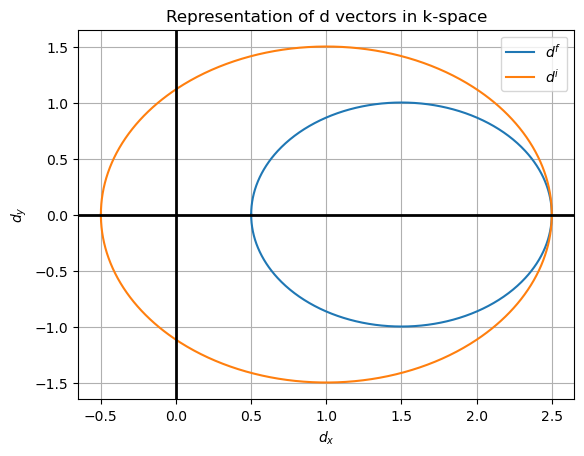

In [11]:
plt.plot(df[:,0] , df[:,1] , label = r"$d^f$")
plt.plot(di[:,0] , di[:,1] , label = r"$d^i$")
plt.xlabel(r'$d_{x}$')
plt.ylabel(r'$d_{y}$')
plt.axvline(linewidth = '2' , color = 'black')
plt.axhline(linewidth = '2' , color = 'black')
# plt.xlim(-6,6)
# plt.ylim(-6,6)
plt.grid()
plt.legend()
plt.title("Representation of d vectors in k-space")

In [12]:
# df_normed

In [13]:
# plt.plot(di_normed[:,0] , di_normed[:,1])
# plt.plot(di[:,0] , di[:,1])
# plt.grid()

In [14]:
"""defining cos(delta_k)"""

cos_delta_k = np.array(len(k)*[0.00])

for i in range(len(k)):
    cos_delta_k[i] = np.dot(di_normed[i] , df_normed[i])

In [15]:
"""Defining the energies as a function of k (dispersion relation)"""

Eik = np.array(len(k)*[0.00])
Efk = np.array(len(k)*[0.00])

for i in range(len(k)):
    Eik[i] = np.sqrt(np.sum(di[i]**2)) 
    Efk[i] = np.sqrt(np.sum(df[i]**2)) 


In [16]:
"""Calculating the critical momentum and critical times"""

Efkc_analytical = np.sqrt(v(quench=True)**2 + w(quench=True)**2 + 2*v(quench=True)*w(quench=True)*np.cos(2.957))

tc_analytical = pi/(2*Efkc_analytical)  #tc assuming continuum limit

index_of_kc = np.where(abs(cos_delta_k) == min(abs(cos_delta_k)))[0]

tc = pi/(2*Efk[index_of_kc])[0]  #tc calculated for our discrete array

In [17]:
#tc/pi

In [18]:
"""Defining the Loschmidt amplitude and the Loschmidt return rate"""

Gk = np.zeros((len(t) , len(k)) , dtype = complex)

for i in tqdm(range(len(t))):
    for k_val in range(len(k)):
        Gk[i,k_val] = complex(np.cos(Efk[k_val]*t[i]) , -cos_delta_k[k_val]*np.sin(Efk[k_val]*t[i]))
        
LE_amp = np.array(len(t)*[1.00] , dtype = complex)

for i in tqdm(range(len(t))):
    for k_val in range(len(k)):
        LE_amp[i] = LE_amp[i]*Gk[i][k_val]
        
rate = (-1/len(k))*np.real(np.log(np.abs(LE_amp)**2))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
# """Defining the Loschmidt amplitude and the Loschmidt return rate"""

# Gk = np.zeros((len(t) , len(k)) , dtype = complex)

# for i in range(len(t)):
#     for k_val in range(len(k)):
#         Gk[i,k_val] = complex(np.cos(Efk[k_val]*t[i]) , -cos_delta_k[k_val]*np.sin(Efk[k_val]*t[i]))
        
# LE_amp = np.array(len(t)*[1.00] , dtype = complex)

# for i in range(len(t)):
#     for k_val in range(len(k)):
#         LE_amp[i] = LE_amp[i]*Gk[i][k_val]
        
# rate = (-1/len(k))*np.real(np.log(np.abs(LE_amp)**2))

In [21]:
"""Defining the Pancharatnam Geometric Phase (PGP) and dnu, where nu = DTOP"""

PGP = np.zeros((len(t) , len(k)))
phi_dyn = np.zeros((len(t) , len(k)))


for i in tqdm(range(len(t))):
    for k_val in range(len(k)):
        phi_dyn[i,k_val] = np.angle(complex(np.cos(-Efk[k_val]*t[i]*cos_delta_k[k_val]) , np.sin(-Efk[k_val]*t[i]*cos_delta_k[k_val])))

for i in tqdm(range(len(t))):  # i know i don't need to loop this, PGP = angle(Gk) - phi_dyn will suffice, will change later
    for k_val in range(len(k)):
        PGP[i,k_val] = make_periodic(np.angle(Gk[i,k_val]) - phi_dyn[i,k_val])




    
# d_dk = FinDiff(0,dk)

# for i in range(len(t)):
#     dnu[i] = d_dk(PGP[i])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
PGP_in_EBZ = PGP[: , np.where(k==0)[0][0]:]

In [23]:
# """In the DTOP paper, the LE is defined as a product of Gk terms for k>0, which is inexplicable to me. Here I try it such 
# that each Gk, k>0 is a product of the k>0 and k<0 terms, and seeing if defining the PGP that way changes anything. 
# The full LE and hence the rate function are unchanged because I'm just regrouping the terms (so that k>0 and k<0 are bunched
# together)"""

# Gk_paper = np.zeros((len(t) , len(k)//2) , dtype = complex)

# for i in range(len(t)):
#     for k_val in range(len(k)//2):
#         Gk_paper[i,k_val] = complex(np.cos(Efk[k_val]*t[i]) , -cos_delta_k[k_val]*np.sin(Efk[k_val]*t[i])) * complex(np.cos(Efk[-k_val]*t[i]) , -cos_delta_k[-k_val]*np.sin(Efk[-k_val]*t[i]))
        
# LE_amp_paper = np.array(len(t)*[1.00] , dtype = complex)

# for i in range(len(t)):
#     for k_val in range(len(k)//2):
#         LE_amp_paper[i] = LE_amp_paper[i]*Gk_paper[i][k_val]
        
# rate_paper = (-1/len(k))*np.real(np.log(np.abs(LE_amp_paper)**2))


# PGP_paper = np.zeros((len(t) , len(k)//2))
# dnu_paper = np.zeros((len(t) , len(k)//2))

# for i in range(len(t)):
#     for k_val in range(len(k)//2):
#         PGP_paper[i,k_val] = np.angle(Gk_paper[i,k_val]) - (Efk[k_val]*t[i]*cos_delta_k[k_val]%(2*pi)) #by theory this should be -Efk ? Check again later
    

# # for i in range(len(t)):
# #     dnu[i] = np.gradient(PGP[i] , k)


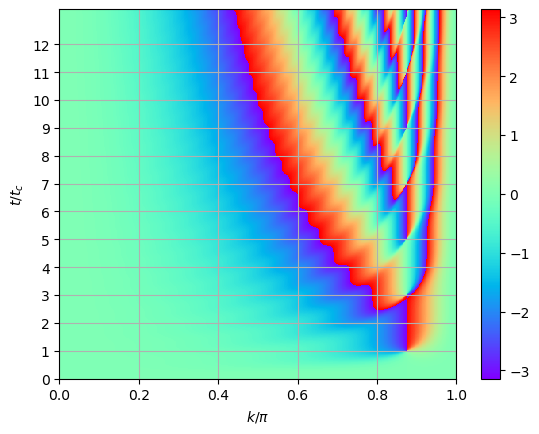

In [24]:
#%matplotlib qt
plt.pcolormesh(k/pi , t/tc , PGP , cmap = 'rainbow')
plt.colorbar()
#plt.grid()
plt.xlabel(r'$k/\pi$')
plt.ylabel(r'$t/t_c$')
# plt.clim(-8 , 0)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.yscale('log')
# #plt.xlim(10,95)
# plt.ylim(10,4000)
plt.xlim(0,1)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()
plt.show()


In [25]:
"""ROUGH WORK"""

'ROUGH WORK'

In [26]:
# (dnu[1000,np.where(k==0)[0][0]:])

In [27]:
a = np.array([])
b = np.append(a , 2)
print(b)

[2.]


In [28]:
# # plt.plot(k/pi , np.gradient(PGP[1000]) , ".")
# # plt.xlabel("k/pi")
# # plt.ylabel("dnu at t[1000]")

# plt.figure()
# plt.plot( PGP[38] , ".")
# #plt.xlabel("k/pi")
# plt.ylabel("PGP at t[1000]")

# # plt.figure()
# # plt.plot(k/pi , np.angle(Gk[1000,:]) , ".")
# # plt.xlabel("k/pi")
# # plt.ylabel("Gk angle at t[1000]")

# # plt.figure()
# # plt.plot(k/pi , phi_dyn[1000] , ".")
# # plt.xlabel("k/pi")
# # plt.ylabel("phi_dyn at t[1000]")

In [30]:
#plt.plot(PGP_in_EBZ[4000] , ".")

In [31]:
# np.sum(np.diff(PGP[40 , kp_index:]))

In [32]:
# plt.plot((PGP[1200 , kp_index:]) , ".")

In [33]:
# np.sum(np.diff((PGP[1500 , kp_index:])))

In [34]:
# plt.plot((np.diff(PGP[400,kp_index:])) , ".")
# np.sum(np.diff(PGP[400,kp_index:]))

In [35]:
# plt.plot(PGP[400 , 0:250]//1)

In [36]:
# plt.plot(np.gradient(PGP[400 , np.where(k==0)[0][0]:]//1) , ".")

In [37]:
#np.sum(np.gradient(PGP[400 , np.where(k==0)[0][0]:]//1))

In [38]:
# x = np.linspace(0,10, 1000)
# y = np.linspace(0,1,1000)
# pl = np.zeros((1000 , 1000))

# for i in range(len(pl)):
#     for j in range(len(pl[i])):
#         pl[i,j] = x[i]*y[j]


In [39]:
# plt.pcolormesh(y , x , pl)
# plt.colorbar()

In [40]:
#np.where(k==0)[0][0]

In [41]:
#plt.plot(k/pi,np.angle(Gk[2]))

In [42]:
#plt.plot(k/pi , np.arctan(cos_delta_k*np.tan(Efk*t[2])))

In [43]:
#dnu_in_EBZ = dnu[: , np.where(k==0)[0][0]:]

In [44]:
"""END OF ROUGH WORK"""

'END OF ROUGH WORK'

In [45]:
pieces = len(PGP)*[0.00]
jump_sizes = len(PGP)*[0.00]

for i in range(len(PGP)):
    #print("index = ",i)
    pieces[i] , jump_sizes[i] = disc_deriv( k , PGP_in_EBZ[i] )

In [48]:
# if jump_sizes[800] == 0:
#     print("hi")

In [49]:
dnu = len(PGP)*[0.00]

for i in range(len(dnu)):
    if not np.shape(jump_sizes[i]): #if there is no jump...
        dnu[i] = forward_difference(pieces[i] , dk)
        
    else:  #if there is a nonzero number of jumps
        dnu[i] = [forward_difference(arr , dk) for arr in pieces[i]]
        
        

In [50]:
nu = len(PGP)*[0.00]

for i in range(len(nu)):
    if not np.shape(jump_sizes[i]): #if there is no jump...
        nu[i] = (1/(2*pi))*np.trapz(pieces[i] , dx = dk)
        
    else:  #if there is a nonzero number of jumps
        nu[i] = (1/(2*pi))*(np.sum([np.trapz(arr , dx = dk) for arr in pieces[i]]) + np.sum(jump_sizes[i]))

In [73]:
np.sum([np.trapz(arr , dx = dk) for arr in pieces[300]])

-1.3470948975063877

([<matplotlib.axis.XTick at 0x2134ba039a0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

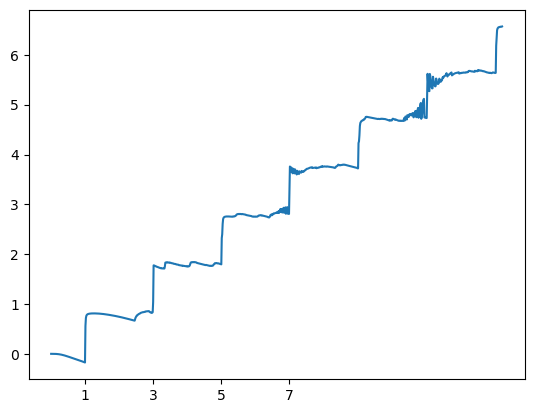

In [52]:
plt.plot(t/tc , nu)
plt.xticks([1,3,5,7])

In [53]:
# plt.plot(PGP_in_EBZ[1077][2160:2200] , ".")
# plt.figure()
# plt.plot(PGP_in_EBZ[1077] , ".")
# print(t[1077]/tc)
# print(jump_sizes[1077])

In [54]:
# a = [1,2,3]
# b = [9,8,7]

# c = [[1,2,3] , [4,5,6]]
# np.concatenate(c)

In [55]:
# """Now defining nu =  integral from k = 0 to pi of dnu"""

# dnu = np.zeros((len(t) , len(k)))

# # d_dk = FinDiff(0,dk)

# # for i in range(len(t)):
# #     dnu[i] = d_dk(PGP[i])

# for i in range(len(t)):
#     dnu[i] = forward_difference(PGP[i] , dk)
    
# dnu_in_EBZ = dnu[: , np.where(k==0)[0][0]:]

# # for i in range(len(t)):
# #     dnu[i] = np.gradient(PGP[i] , k)

# nu = np.array(len(t)*[0.00])

# for i in range(len(t)):
#     nu[i] = (1/2*pi)*np.trapz(dnu_in_EBZ[i] , dx = dk)
    

In [56]:
# """Now defining nu =  integral from k = 0 to pi of dnu"""

# for i in range(len(t)):
#     dnu[i] = np.gradient(PGP[i] , k)

# nu = np.array(len(t)*[0.00])

# for i in range(len(t)):
#     nu[i] = (1/2*pi)*np.trapz(dnu_in_EBZ[i] , dx = dk)
    

In [57]:
# np.trapz(dnu_in_EBZ[100] , dx = dk)

In [58]:
# np.sum(dnu_in_EBZ[100]*dk)

In [59]:
# sum(dnu_in_EBZ[100])

In [60]:
# sum(sorted(dnu_in_EBZ[100])[:30])

In [61]:
# test = np.array(len(PGP[1000])*[0.00])

# for i in range(len(PGP[1000])-1):
#     test[i] = (PGP[1000,i+1]-PGP[1000,i])/dk
# test[-1] = test[-2]
    
# plt.plot(test[np.where(k==0)[0][0]:] , ".")
# plt.ylim(-100,100)    


In [62]:
#sorted(test[500:])

In [63]:
# plt.plot(k[np.where(k==0)[0][0]:] , dnu_in_EBZ[1000] , "x")
# #plt.ylim(-20,20)

In [64]:
# dk = k[1]-k[0]

In [65]:
# # plt.plot(k , dnu[800])
# # plt.figure()
# plt.plot(k/pi , PGP[970] , ".")
# plt.xlim(0,1)

In [66]:
# np.where(t>tc)

Text(0.5, 0, 'Time')

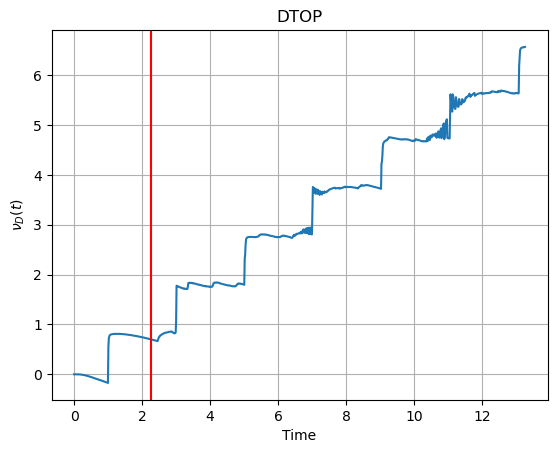

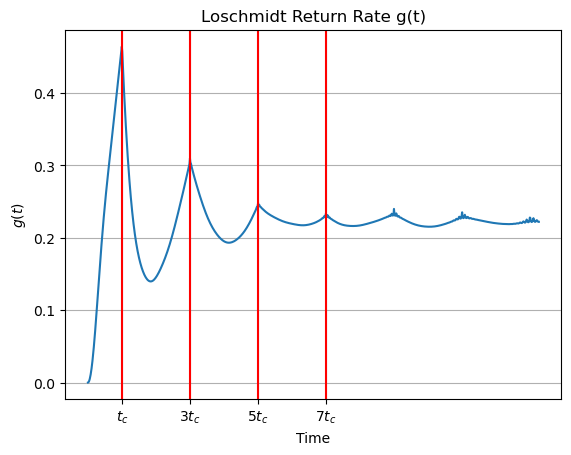

In [75]:
plt.plot(t/tc , nu)
plt.ylabel(r'$\nu_{D}(t)$')
plt.xlabel('Time')
plt.grid()
# plt.xlim(0,1)
# plt.ylim(0,40)
#plt.axvline(tc)
plt.title("DTOP")
plt.axvline(tc , color='red')
#plt.ylim(-2,2)
plt.savefig("DTOP_plot.png")

plt.figure()
plt.plot(t,rate)
plt.grid()
plt.axvline(tc , color='red')
plt.axvline(3*tc , color='red')
plt.axvline(5*tc , color='red')
plt.axvline(7*tc , color='red')
plt.xticks([tc , 3*tc , 5*tc , 7*tc] , [r'$t_c$' , r'$3t_c$' , r'$5t_c$' , r'$7t_c$'])
plt.title("Loschmidt Return Rate g(t)")
plt.ylabel(r'$g(t)$')
plt.xlabel('Time')


#plt.ylim(0,2)
#plt.xlim(0,1)

In [ ]:
"""Rough work begins here"""

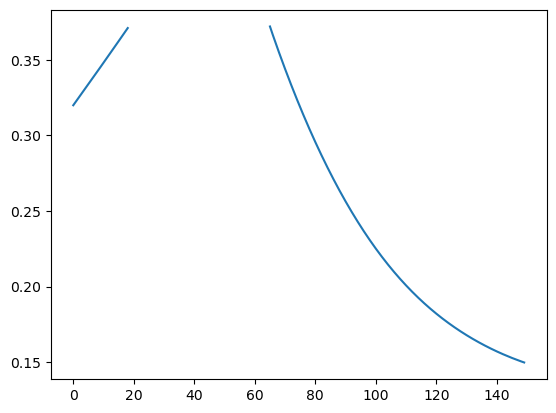

In [55]:
plt.plot(rate[100:250])

In [54]:
print(rate[100:200])

[0.31991641 0.32271724 0.32551842 0.32832107 0.33112621 0.33393479
 0.33674766 0.33956558 0.34238921 0.34521912 0.3480558  0.35089962
 0.3537509  0.35660982 0.35947652 0.36235103 0.36523329 0.36812315
 0.37099482        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf 0.37203402
 0.36609219 0.36038095 0.35477904 0.34928472 0.34389632 0.33861222
 0.33343091 0.32835089 0.32337075 0.31848913 0.31370469 0.30901616
 0.3044223  0.29992189 0.29551377 0.29119676 0.28696975 0.28283162
 0.27878127 0.27481762 0.27093957 0.26714606 0.26343602 0.2598

Text(0, 0.5, '$\\cos(\\Delta_k)$')

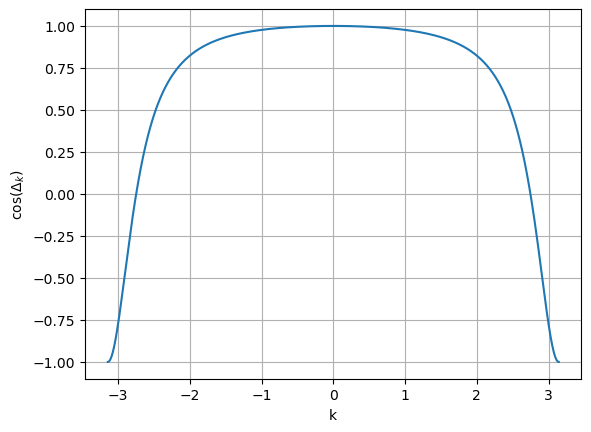

In [56]:
plt.plot(k , cos_delta_k)
plt.grid()
plt.xlabel("k")
plt.ylabel(r'$\cos(\Delta_k)$')

Text(0.5, 0, 'k')

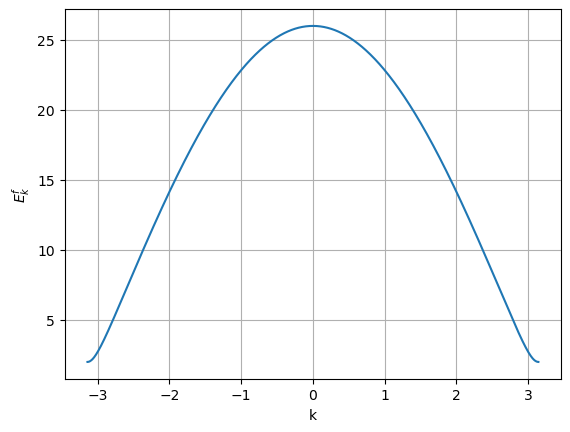

In [23]:
plt.plot(k , Efk)
plt.grid()
plt.ylabel(r'$E^f_k$')
plt.xlabel('k')

In [24]:
np.where(abs(cos_delta_k) == min(abs(cos_delta_k)))

(array([970], dtype=int64),)

In [25]:
pi/(2*Efk[25])

0.5503952748112202

In [200]:
np.sqrt(1.95928417e-01**2 +  2.69672331e-01**2)

0.33333333270931587

In [201]:
Efk

array([ 1.        ,  1.00308073,  1.01226654,  1.02739334,  1.04820337,
        1.07436563,  1.10549922,  1.14119614,  1.18104136,  1.22462853,
        1.27157127,  1.32151029,  1.37411709,  1.42909513,  1.48617921,
        1.54513381,  1.60575071,  1.66784641,  1.73125948,  1.79584799,
        1.86148718,  1.92806727,  1.99549159,  2.06367485,  2.1325417 ,
        2.20202541,  2.27206675,  2.34261306,  2.41361741,  2.48503784,
        2.55683677,  2.62898048,  2.70143859,  2.77418373,  2.84719112,
        2.92043832,  2.99390493,  3.06757239,  3.14142376,  3.21544355,
        3.28961755,  3.36393273,  3.43837709,  3.51293957,  3.58760995,
        3.66237876,  3.73723722,  3.81217718,  3.88719106,  3.96227176,
        4.03741267,  4.1126076 ,  4.18785075,  4.26313666,  4.33846021,
        4.41381657,  4.48920119,  4.56460974,  4.64003816,  4.71548258,
        4.79093933,  4.86640492,  4.94187603,  5.01734949,  5.09282228,
        5.16829151,  5.24375441,  5.31920833,  5.39465072,  5.47

In [202]:
cos_delta_k

array([-1.        , -0.99516543, -0.98089725, -0.95786851, -0.92709857,
       -0.88982742, -0.84738424, -0.80107342, -0.75209183, -0.70147989,
       -0.65010222, -0.59864974, -0.54765521, -0.49751519, -0.44851381,
       -0.40084542, -0.3546345 , -0.30995241, -0.266831  , -0.22527326,
       -0.18526164, -0.14676434, -0.10974002, -0.07414129, -0.03991723,
       -0.00701528,  0.02461752,  0.05503359,  0.08428423,  0.11241919,
        0.13948646,  0.16553212,  0.19060026,  0.21473301,  0.23797058,
        0.26035127,  0.28191156,  0.30268623,  0.32270837,  0.34200951,
        0.3606197 ,  0.37856757,  0.39588041,  0.41258425,  0.42870393,
        0.44426315,  0.45928453,  0.47378969,  0.48779926,  0.50133299,
        0.51440972,  0.52704748,  0.53926352,  0.55107434,  0.5624957 ,
        0.57354272,  0.58422986,  0.59457094,  0.60457922,  0.61426738,
        0.62364758,  0.63273146,  0.64153016,  0.65005438,  0.65831434,
        0.66631986,  0.67408035,  0.68160482,  0.68890192,  0.69

In [203]:
di_normed[30] , df_normed[30]

(array([0.90237501, 0.43095167]), array([-0.30086958,  0.9536653 ]))

In [204]:
di[30]/np.sqrt(np.sum(di[30]**2)) , df[30]/np.sqrt(np.sum(df[30]**2))

(array([0.90237501, 0.43095167]), array([-0.30086958,  0.9536653 ]))

In [205]:
np.where(abs(cos_delta_k) < 0.01)

(array([ 25, 974], dtype=int64),)

In [206]:
cos_delta_k[25]

-0.007015277050193391

In [207]:
cos_delta_k

array([-1.        , -0.99516543, -0.98089725, -0.95786851, -0.92709857,
       -0.88982742, -0.84738424, -0.80107342, -0.75209183, -0.70147989,
       -0.65010222, -0.59864974, -0.54765521, -0.49751519, -0.44851381,
       -0.40084542, -0.3546345 , -0.30995241, -0.266831  , -0.22527326,
       -0.18526164, -0.14676434, -0.10974002, -0.07414129, -0.03991723,
       -0.00701528,  0.02461752,  0.05503359,  0.08428423,  0.11241919,
        0.13948646,  0.16553212,  0.19060026,  0.21473301,  0.23797058,
        0.26035127,  0.28191156,  0.30268623,  0.32270837,  0.34200951,
        0.3606197 ,  0.37856757,  0.39588041,  0.41258425,  0.42870393,
        0.44426315,  0.45928453,  0.47378969,  0.48779926,  0.50133299,
        0.51440972,  0.52704748,  0.53926352,  0.55107434,  0.5624957 ,
        0.57354272,  0.58422986,  0.59457094,  0.60457922,  0.61426738,
        0.62364758,  0.63273146,  0.64153016,  0.65005438,  0.65831434,
        0.66631986,  0.67408035,  0.68160482,  0.68890192,  0.69

In [208]:
Efk

array([ 1.        ,  1.00308073,  1.01226654,  1.02739334,  1.04820337,
        1.07436563,  1.10549922,  1.14119614,  1.18104136,  1.22462853,
        1.27157127,  1.32151029,  1.37411709,  1.42909513,  1.48617921,
        1.54513381,  1.60575071,  1.66784641,  1.73125948,  1.79584799,
        1.86148718,  1.92806727,  1.99549159,  2.06367485,  2.1325417 ,
        2.20202541,  2.27206675,  2.34261306,  2.41361741,  2.48503784,
        2.55683677,  2.62898048,  2.70143859,  2.77418373,  2.84719112,
        2.92043832,  2.99390493,  3.06757239,  3.14142376,  3.21544355,
        3.28961755,  3.36393273,  3.43837709,  3.51293957,  3.58760995,
        3.66237876,  3.73723722,  3.81217718,  3.88719106,  3.96227176,
        4.03741267,  4.1126076 ,  4.18785075,  4.26313666,  4.33846021,
        4.41381657,  4.48920119,  4.56460974,  4.64003816,  4.71548258,
        4.79093933,  4.86640492,  4.94187603,  5.01734949,  5.09282228,
        5.16829151,  5.24375441,  5.31920833,  5.39465072,  5.47

In [209]:
min(abs(cos_delta_k))

0.007015277050193391

In [210]:
np.where(abs(cos_delta_k) == min(abs(cos_delta_k)))

(array([25], dtype=int64),)

In [211]:
cos_delta_k[80]

0.7614368924068418

In [212]:
cos_delta_k[27]

0.05503359242062322

In [213]:
Efk

array([ 1.        ,  1.00308073,  1.01226654,  1.02739334,  1.04820337,
        1.07436563,  1.10549922,  1.14119614,  1.18104136,  1.22462853,
        1.27157127,  1.32151029,  1.37411709,  1.42909513,  1.48617921,
        1.54513381,  1.60575071,  1.66784641,  1.73125948,  1.79584799,
        1.86148718,  1.92806727,  1.99549159,  2.06367485,  2.1325417 ,
        2.20202541,  2.27206675,  2.34261306,  2.41361741,  2.48503784,
        2.55683677,  2.62898048,  2.70143859,  2.77418373,  2.84719112,
        2.92043832,  2.99390493,  3.06757239,  3.14142376,  3.21544355,
        3.28961755,  3.36393273,  3.43837709,  3.51293957,  3.58760995,
        3.66237876,  3.73723722,  3.81217718,  3.88719106,  3.96227176,
        4.03741267,  4.1126076 ,  4.18785075,  4.26313666,  4.33846021,
        4.41381657,  4.48920119,  4.56460974,  4.64003816,  4.71548258,
        4.79093933,  4.86640492,  4.94187603,  5.01734949,  5.09282228,
        5.16829151,  5.24375441,  5.31920833,  5.39465072,  5.47

In [214]:
di[10]/(np.sqrt(di[10,0]**2 + di[10,1]**2)) , df[10]/(np.sqrt(df[10,0]**2 + df[10,1]**2))

(array([0.98638384, 0.16445946]), array([-0.76621431,  0.64258511]))

In [215]:
np.array([complex(1,2) , 0])

array([1.+2.j, 0.+0.j])

In [216]:
pi/(2*Efk[20])

0.8438394563456443

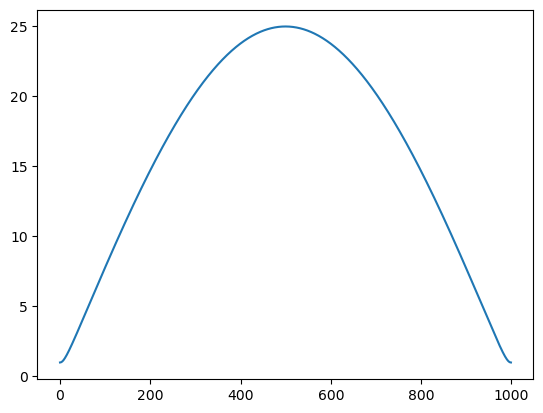

In [218]:
plt.plot(Efk)

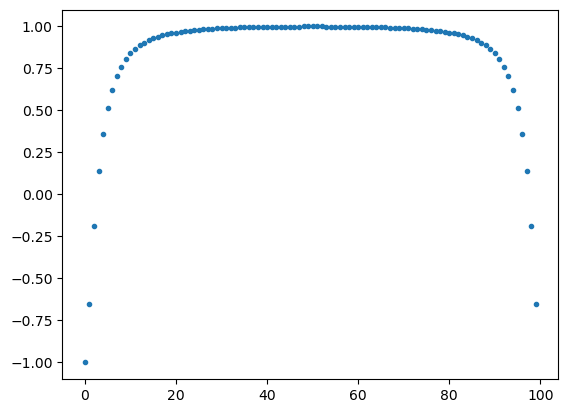

In [174]:
vp = v(quench=True)
vn = v()
wp = w(quench=True)
wn = w()

dd = vn*vp + wn*wp + (wn*vp + vn*wp)*np.cos(k)
denom = Eik*Efk

plt.plot(dd/denom , '.')

In [170]:
(wn*vp + vn*wp)

TypeError: can only concatenate tuple (not "int") to tuple

In [173]:
min(abs(cos_delta_k))

0.1386895361573503

In [65]:
tt = np.linspace(-4*pi , 4*pi , 1000)
w = np.linspace(-pi,pi,1000)

In [78]:
comp = [complex(np.cos(t_t) , np.sin(t_t)) for t_t in tt]

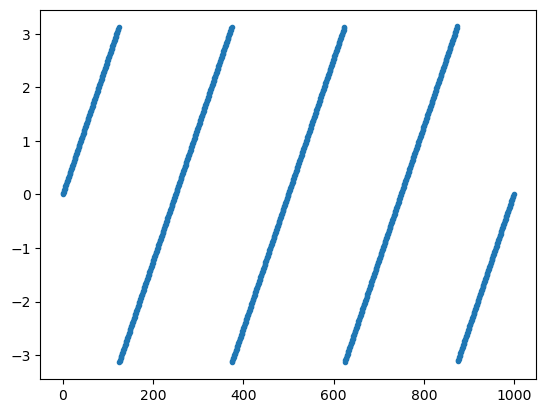

In [79]:
plt.plot(np.angle(comp) , ".")